# VR Z' jet selection

Ok, so a comment that I get *every* time I give this talk is that Chris wants me to only look at the two Z' jets that are leading in $p_T$.

We decided that in the standard hybrid definition, the track jet $p_T$ cut at 125 GeV protected us from most of the low energy FSR jets, as demonstrated by the njets plot below, which shows that with this 125 GeV cut, most of the Z' events have only a small number of events with 3 or more jets. 

<img src="../../figures/mc16d_VR_Zprime_1.5TeV/nJets_varyHybridCuts.pdf" width="400">

Based on this, we decided that it doesn't matter if we select the leading two jets in the hybrid definition or not. However, when *evaluating* on the inclusive Z' sample, we might want to focus on just the two leading jets. 

However, the Z' rejection plots that I showed in the algs meeting on April $11^{th}$ showed that the rejections were flat w/r.t. $p_T$ (reproduced below).

l-rej             |  c-rej
:-------------------------:|:-------------------------:
![](../../figures/mc16d_VR_Zprime_1.5TeV/l-rej_vs_pT_flatEff_rej_cf_pflow.pdf)  |  ![](../../figures/mc16d_VR_Zprime_1.5TeV/l-rej_vs_pT_flatEff_rej_cf_pflow.pdf)

I think this means that the low $p_T$ region of the Z' sample is *not* driving the overall performance of the roc curves, but still... something worth checking!


**Plan:** Compare the roc curves and $p_T$ and $\eta$ plots for the two versions of the Z' plots on 
1. The model with the dedicated Z' training
2. The hybrid model with the new cut at 125 GeV and the three output nodes

In [2]:
import numpy as np
import h5py
import sys
import pandas as pd
import xarray as xr

sys.path.append("../..")
from usefulFcts import *
from trainNet import *
from plottingFcts import *

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## Retrieve the data and the models

In [3]:
trJetCol = 'VR'
jetCollection = 'VR'
Ntrain = int(3e6)
Ntest =  int(1.5e6)
nTrks_te = 25

vStr = "sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits"

nFeatures=13
figDir = '../../figures/' 

In [4]:
leffs, ceffs, beffs, = [],[],[]
discs, labels = [],[]
ys, pts, etas = [],[],[]

for physicsSample, miniJetTag in zip(['Zprime_1.5TeV','Zprime_1.5TeV_2lead'],['2m','1000k']):
        
    print('Evaluating on '+physicsSample)
        
    for trainPhysicsSample, nHidden, nTrks_tr, nClasses in \
        zip(['Zprime_1.5TeV','hybrid_1.5TeV_cut_125GeV'], [200,300], [25,15], [4,3]):
        
        # Load in the sample for evaluation
        subDir = 'mc16d_{}_{}'.format(jetCollection,physicsSample)
        dataDir = '../../data/'+subDir
        scale_tag = "_{}_scale".format(trainPhysicsSample) if physicsSample != trainPhysicsSample else ""
        if trJetCol != jetCollection:
            scale_tag = '_' + trJetCol + scale_tag

        dataTagTest = "{}test_{}trks_{}_sd0_rev{}".format(miniJetTag,nTrks_te,vStr, scale_tag)

        f_name = "{}/data_{}.hdf5".format(dataDir,dataTagTest)
        f = h5py.File(f_name,"r")

        X = f['X_test'][:]
        y = f['y_test'][:]
        ix = f['ix_test'][:]

        f.close()

        # Only keep the events without taus, since these models were only trained w/ 
        # 3 output classes
        if trainPhysicsSample == 'hybrid_1.5TeV_cut_125GeV':
            notaus = (y != 3)
            X  = X[notaus]
            y  = y[notaus]
            ix = ix[notaus]
          
        # If we're evaluating the model that has been trained on 
        nTest = X.shape[0]
        if nTrks_te > nTrks_tr:
            # Restrict the # of tracks you're evaluating with
            X = X[:,:nTrks_tr,:]
        if nTrks_te < nTrks_tr:
            # Append 0s
            zeros = np.zeros((nTest,nTrks_tr-nTrks_te,nFeatures))
            X = np.concatenate((X,zeros),axis=1)

        # Also open the df so that you'll have access to the jet pt and eta
        jet_df = pd.read_hdf('{}/jet_{}test_25trks_sd0_rev.h5'.format(dataDir,miniJetTag), key='jet_df')

        # Load in the model
        modelDir = "../../models/mc16d_{}_{}".format(trJetCol,trainPhysicsSample)
        dataTagTrain = "{}train_{}trks_{}_sd0_rev".format(nJetsTag(Ntrain),nTrks_tr,vStr)
        m = myLSTM(modelDir=modelDir, nFeatures=nFeatures, nHidden=nHidden, 
                   dataTag=dataTagTrain, loadModel=True, nClasses=nClasses)

        # Get the efficiencies
        tag = '_eval_{}'.format(physicsSample) if physicsSample != trainPhysicsSample else ''
        (leff, ceff, beff), d = getEffs(m, X, y, ix, returnDisc=True,
                                        figDir=figDir,subDir=subDir,modelDir=modelDir,tag=tag)

        leffs.append(leff)
        ceffs.append(ceff)
        beffs.append(beff)

        discs.append(d)
        labels.append('train {}, eval {}'.format(trainPhysicsSample,physicsSample))

        ys.append(y)
        pts.append(jet_df.pt.values)
        etas.append(jet_df.eta.values)


Evaluating on Zprime_1.5TeV
Initialize method from myModel()
Loading previously trained LSTM
Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained LSTM
Load in the previously saved efficiency file
Evaluating on Zprime_1.5TeV_2lead
Initialize method from myModel()
Loading previously trained LSTM
Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained LSTM
Load in the previously saved efficiency file


### Overall roc curves

In [14]:
train_labels = ["{} training eval on {} jets".format(physicsSample,jets) \
                for jets in ['all','2 leading'] for physicsSample in ['Z\'','hybrid with 125 GeV cut']]
train_labels

["Z' training eval on all jets",
 'hybrid with 125 GeV cut training eval on all jets',
 "Z' training eval on 2 leading jets",
 'hybrid with 125 GeV cut training eval on 2 leading jets']

../../plottingFcts.py:559: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


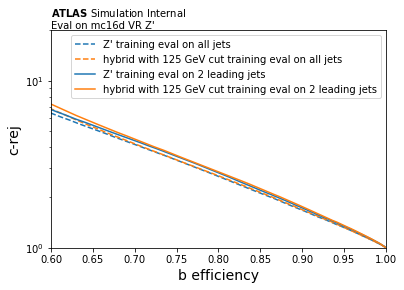

In [16]:
figDir = '../../figures/'
subDir = 'mc16d_VR_Zprime_1.5TeV'
plotTag = 'rej_cf_2lead'

text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+=r"Eval on mc16d VR Z'"

colors = ['C0','C1','C0','C1']
styles = ['--','--','-','-']

plotROC(beffs, leffs, train_labels, ymax=1000,
        text=text,ylabel='l-rej', colors=colors ,styles=styles,
        figDir=figDir,subDir=subDir,tag='l'+plotTag)

plotROC(beffs, ceffs, train_labels, ymax=20,
        text=text,ylabel='c-rej', colors=colors ,styles=styles,
        figDir=figDir,subDir=subDir,tag='c'+plotTag)

I'm not going to make the $p_T$ and $\eta$ plots, because right now my scripts assume that I'm using the *same* $p_T$ and $\eta$ for all the curves, and I kind of don't want to refactor this function right now.